In [1]:
# Importing Packages

import numpy as np
import matplotlib.pyplot as plt
import time

from typing import Optional, Union

import jax
import jax.numpy as jnp
from jax.scipy.special import erf
from jax import jit, vmap, block_until_ready

from rl_algos.ppo_clipped_normal import PPO_make_train as PPO_Clipped_make_train

In [2]:
# Seeding everything

seed = 30

rng = jax.random.PRNGKey(seed)
rng, _rng = jax.random.split(rng)

## Default Training

In [3]:
# Defining Sherbrooke Params and RL Params

tau_0 = 0.783
kappa = 14.31
chi = 0.31 * 2. * jnp.pi
kerr = 0.00
n0 = 53.8
res_amp_scaling = 1/0.348
actual_max_photons = n0 * (1. - 2. * jnp.cos(0.5 * chi * tau_0) * jnp.exp(-0.5 * kappa * tau_0) + jnp.exp(-0.5 * kappa * tau_0))
print(f"Rough Max Photons: {n0}")
print(f"Actual Max Photons: {actual_max_photons}")
nR = 0.01
snr_scale_factor = 1.1
gamma_I = 1/362.9
photon_gamma = 1/4000
init_fid = 1.

time_coeff = 10.0
snr_coeff = 20.0
smoothness_coeff = 10.0
smoothness_baseline_scale = 1.0
apply_smoothing = True
use_processed_action = True
bandwidth = 50.0
freq_relative_cutoff = 0.1
bandwidth_coeff = 0.0
apply_bandwidth_constraint = False
num_t1 = 9.0
photon_weight = 12.0
shot_noise_std = 0.0
standard_fid = 0.99

env_config = {"kappa": kappa,
    "chi": chi,
    "kerr": kerr,
    "time_coeff": time_coeff,
    "snr_coeff": snr_coeff,
    "smoothness_coeff": smoothness_coeff,
    "smoothness_baseline_scale": smoothness_baseline_scale,
    "apply_smoothing": apply_smoothing,
    "use_processed_action": use_processed_action,
    "bandwidth": bandwidth,
    "freq_relative_cutoff": freq_relative_cutoff,
    "bandwidth_coeff": bandwidth_coeff,
    "apply_bandwidth_constraint": apply_bandwidth_constraint,
    "n0": n0,
    "tau_0": tau_0,
    "res_amp_scaling": res_amp_scaling,
    "nR": nR,
    "snr_scale_factor": snr_scale_factor,
    "gamma_I": gamma_I,
    "photon_gamma": photon_gamma,
    "num_t1": num_t1,
    "init_fid": init_fid,
    "photon_weight": photon_weight,
    "standard_fid": standard_fid,
    "shot_noise_std": shot_noise_std,
}

num_envs = 256
num_updates = 4000
config = {
    "LR": 3e-4,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": 1,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 64,
    "ENV_NAME": "single_langevin_env",
    "ENV_PARAMS": env_config,
    "ANNEAL_LR": False,
    "DEBUG": True,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

Rough Max Photons: 53.8
Actual Max Photons: 53.711451977836106


In [4]:
from utils import photon_env_dicts

env = photon_env_dicts()[config["ENV_NAME"]](**config["ENV_PARAMS"])

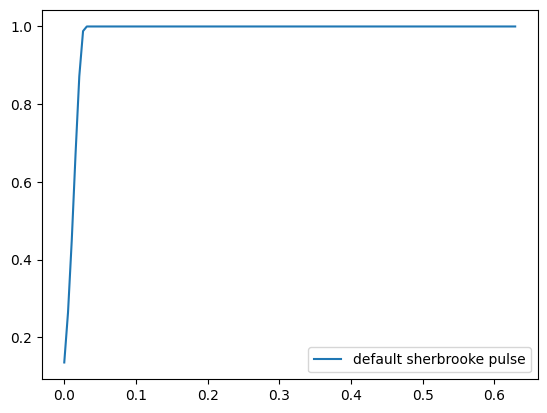

In [5]:
# Default Sherbrooke Action

ts = env.ts_action

gauss_sigma = 0.0142
num_sigma = 2.
total_duration = tau_0

default_pulse = jnp.heaviside((total_duration - num_sigma * gauss_sigma) - ts, 1.) * jnp.heaviside(ts - num_sigma * gauss_sigma, 0.)
default_pulse += jnp.heaviside(num_sigma * gauss_sigma - ts, 1.) * jnp.exp(-(ts - num_sigma * gauss_sigma)**2 / (2 * gauss_sigma**2))
default_pulse += jnp.heaviside(ts - (total_duration - num_sigma * gauss_sigma), 1.) * jnp.exp(-(ts - (total_duration - num_sigma * gauss_sigma))**2 / (2 * gauss_sigma**2))

plt.plot(ts, default_pulse, label='default sherbrooke pulse')
plt.legend()
plt.show()

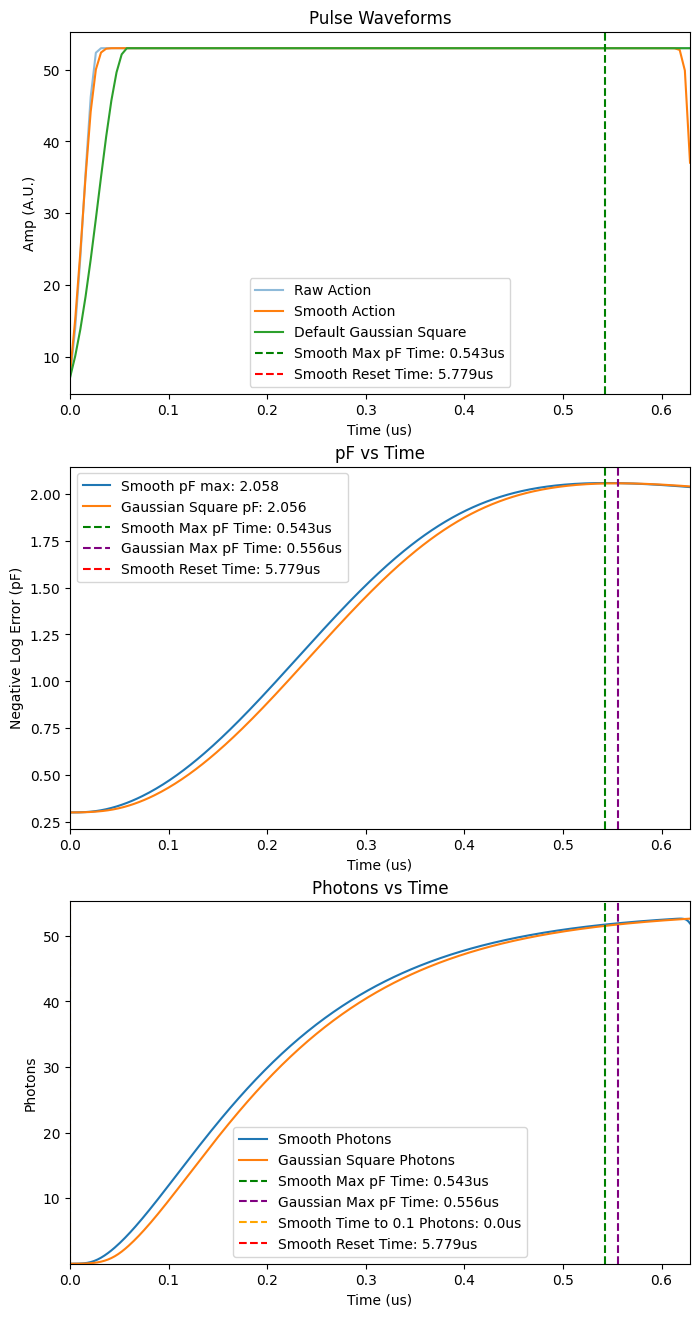

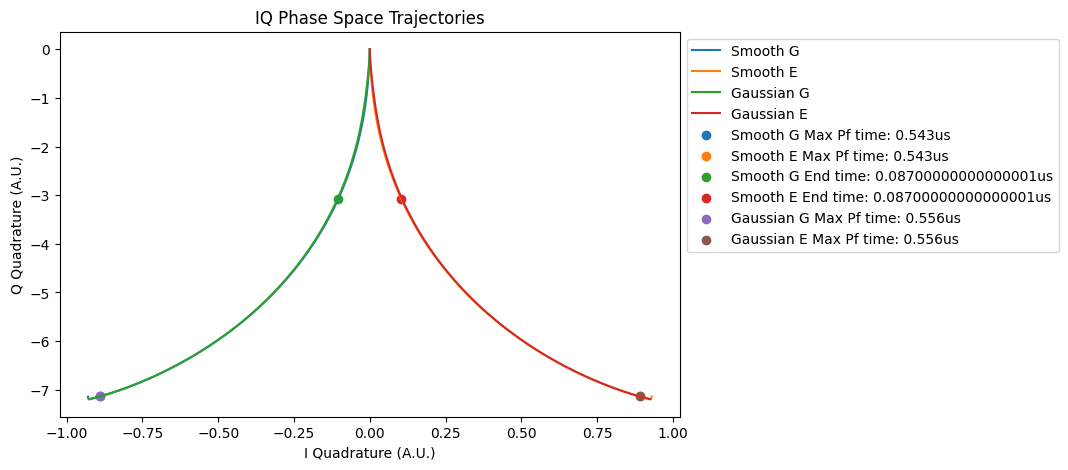

In [6]:
env.rollout_action(_rng, default_pulse)

## Starting Training

In [7]:
single_train = jit(PPO_Clipped_make_train(config), static_argnums=-1)

print(f"Starting a Run of {num_updates} Updates")
start = time.time()
single_result = single_train(
    _rng, 
    num_envs)
end = time.time()
print(f"time taken: {end - start}")

Starting a Run of 4000 Updates
global update: 100
reward: -30.014
max pF: 1.469
max photon: 43.935
photon time: 0.9891000000000001
smoothness: 0.009642999999999999
bandwidth: 40.635
global update: 200
reward: -17.952
max pF: 1.557
max photon: 46.258
photon time: 0.7284
smoothness: 0.007831
bandwidth: 36.299
global update: 300
reward: -7.006
max pF: 1.573
max photon: 44.44
photon time: 0.7818
smoothness: 0.006124999999999999
bandwidth: 34.143
global update: 400
reward: 1.232
max pF: 1.6380000000000001
max photon: 45.563
photon time: 0.8549
smoothness: 0.004947
bandwidth: 31.469
global update: 500
reward: 7.837
max pF: 1.7510000000000001
max photon: 49.647
photon time: 0.7297
smoothness: 0.003968
bandwidth: 26.289
global update: 600
reward: 12.950000000000001
max pF: 1.7850000000000001
max photon: 49.971000000000004
photon time: 0.6692
smoothness: 0.003505
bandwidth: 23.721
global update: 700
reward: 16.579
max pF: 1.792
max photon: 50.124
photon time: 0.6263000000000001
smoothness: 0.00

In [8]:
# Extracting Results

metrics = single_result["metrics"]

rewards = metrics["reward"]
max_pFs = metrics["max pF"]
max_photons = metrics["max photon"]
photon_times = metrics["photon time"]
smoothnesses = metrics["smoothness"]
bandwidths = metrics["bandwidth"]
actions = metrics["action"]

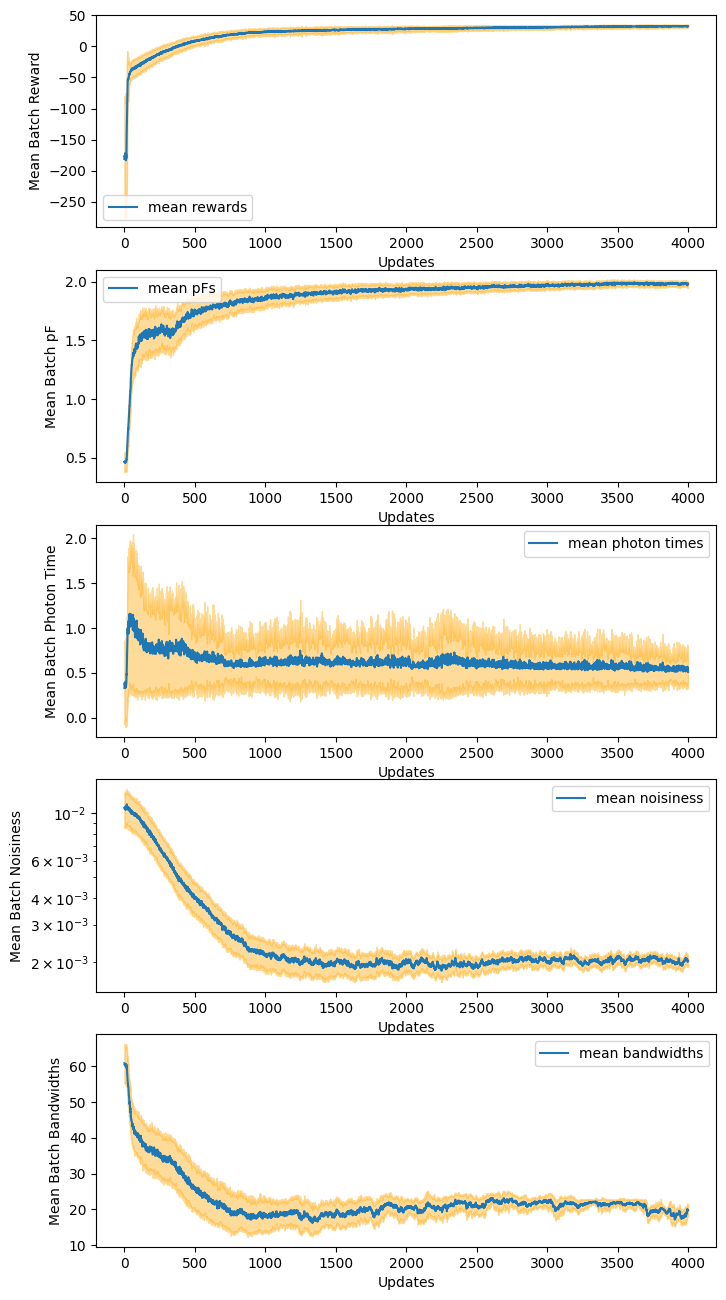

In [9]:
from utils import plot_learning

plot_learning(
    rewards=rewards,
    max_pFs=max_pFs,
    photon_times=photon_times,
    smoothnesses=smoothnesses,
    bandwidths=bandwidths,
)

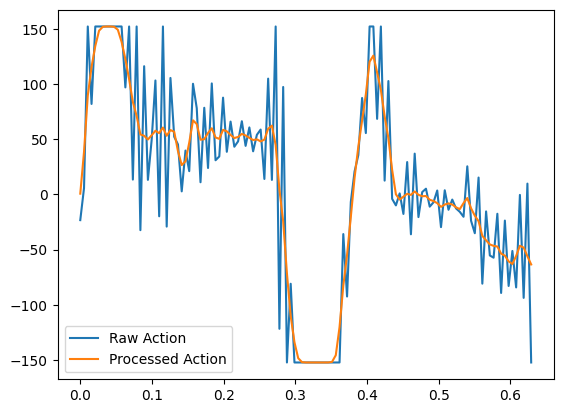

In [10]:
final_action = -actions[-1, 0]
final_processed_action = env.prepare_action(final_action)

plt.plot(env.ts_action, final_action * env.a0, label='Raw Action')
plt.plot(env.ts_action, final_processed_action, label='Processed Action')
plt.legend()
plt.show()

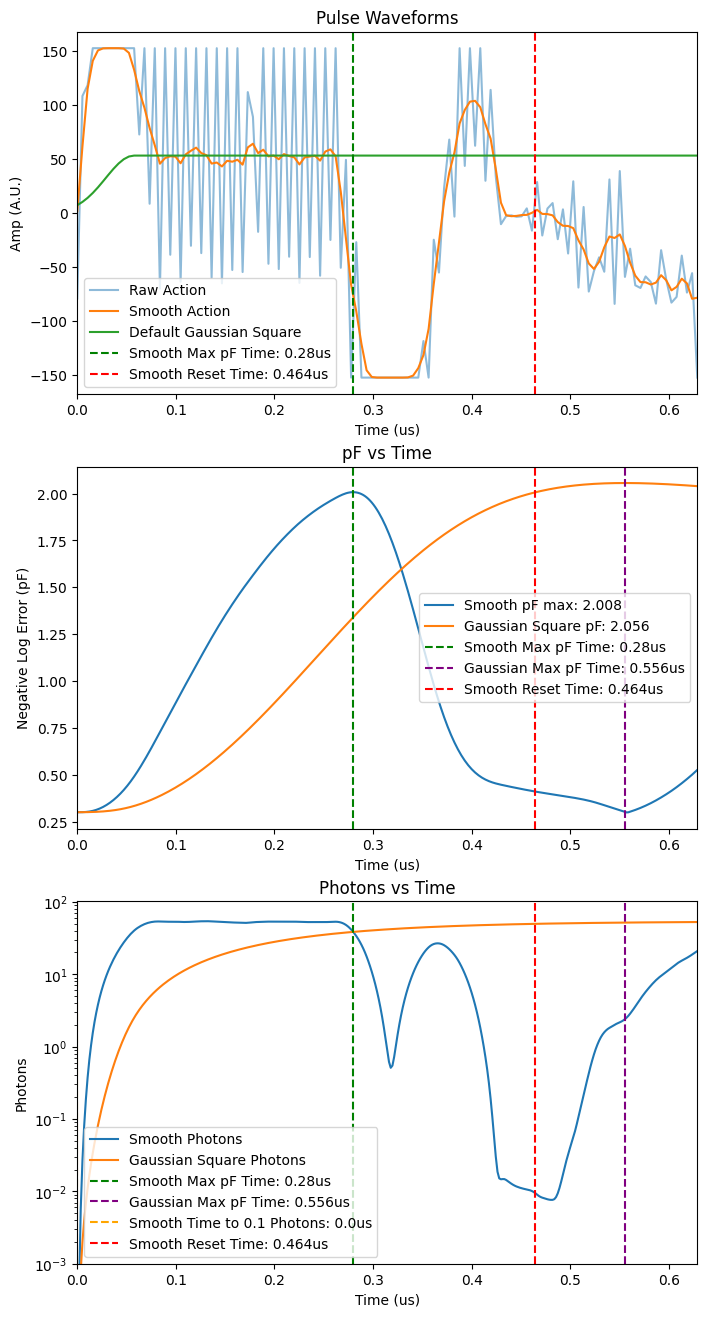

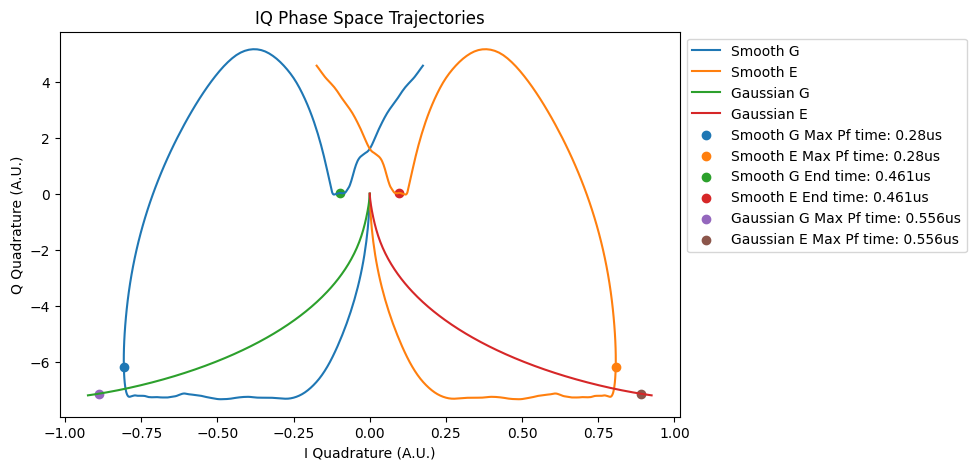

In [33]:
env.rollout_action(_rng, final_action, photon_log_scale=True)

## Training with Direct nR = 0.1

In [34]:
import copy

config_2 = copy.deepcopy(config)
config_2["ENV_PARAMS"]["nR"] = 0.1
config_2["ENV_PARAMS"]["num_t1"] = 7.

config_2

{'LR': 0.0003,
 'NUM_ENVS': 256,
 'NUM_STEPS': 1,
 'NUM_UPDATES': 4000,
 'UPDATE_EPOCHS': 4,
 'NUM_MINIBATCHES': 4,
 'CLIP_EPS': 0.2,
 'VALUE_CLIP_EPS': 0.2,
 'ENT_COEF': 0.0,
 'VF_COEF': 0.5,
 'MAX_GRAD_NORM': 0.5,
 'ACTIVATION': 'relu6',
 'LAYER_SIZE': 128,
 'ENV_NAME': 'single_langevin_env',
 'ENV_PARAMS': {'kappa': 14.31,
  'chi': 1.9477874452256718,
  'kerr': 0.0,
  'time_coeff': 10.0,
  'snr_coeff': 20.0,
  'smoothness_coeff': 10.0,
  'smoothness_baseline_scale': 1.0,
  'apply_smoothing': True,
  'use_processed_action': True,
  'bandwidth': 50.0,
  'freq_relative_cutoff': 0.1,
  'bandwidth_coeff': 0.0,
  'apply_bandwidth_constraint': False,
  'n0': 53.8,
  'tau_0': 0.783,
  'res_amp_scaling': 2.873563218390805,
  'nR': 0.1,
  'snr_scale_factor': 1.1,
  'gamma_I': 0.002755580049600441,
  'photon_gamma': 0.00025,
  'num_t1': 7.0,
  'init_fid': 1.0,
  'photon_weight': 12.0,
  'standard_fid': 0.99,
  'shot_noise_std': 0.0},
 'ANNEAL_LR': False,
 'DEBUG': True,
 'DEBUG_ACTION': False,

In [35]:
single_train_2 = jit(PPO_Clipped_make_train(config_2), static_argnums=-1)

print(f"Starting a Run of {num_updates} Updates")
start = time.time()
single_result_2 = single_train_2(
    _rng, 
    num_envs)
end = time.time()
print(f"time taken: {end - start}")

Starting a Run of 4000 Updates
global update: 100
reward: -23.31
max pF: 1.613
max photon: 45.606
photon time: 0.8460000000000001
smoothness: 0.007401
bandwidth: 47.707
global update: 200
reward: -13.252
max pF: 1.688
max photon: 47.195
photon time: 0.8512000000000001
smoothness: 0.006091999999999999
bandwidth: 43.7
global update: 300
reward: -0.17500000000000002
max pF: 1.7530000000000001
max photon: 49.1
photon time: 0.7240000000000001
smoothness: 0.0045839999999999995
bandwidth: 38.394
global update: 400
reward: 7.224
max pF: 1.811
max photon: 50.575
photon time: 0.6733
smoothness: 0.003757
bandwidth: 34.046
global update: 500
reward: 12.906
max pF: 1.862
max photon: 51.529
photon time: 0.6687000000000001
smoothness: 0.002993
bandwidth: 29.191
global update: 600
reward: 18.207
max pF: 1.8800000000000001
max photon: 51.384
photon time: 0.6435000000000001
smoothness: 0.00268
bandwidth: 26.839000000000002
global update: 700
reward: 20.002
max pF: 1.869
max photon: 50.466
photon time: 0

In [36]:
# Extracting Results

metrics_2 = single_result_2["metrics"]

rewards_2 = metrics_2["reward"]
max_pFs_2 = metrics_2["max pF"]
max_photons_2 = metrics_2["max photon"]
photon_times_2 = metrics_2["photon time"]
smoothnesses_2 = metrics_2["smoothness"]
bandwidths_2 = metrics_2["bandwidth"]
actions_2 = metrics_2["action"]

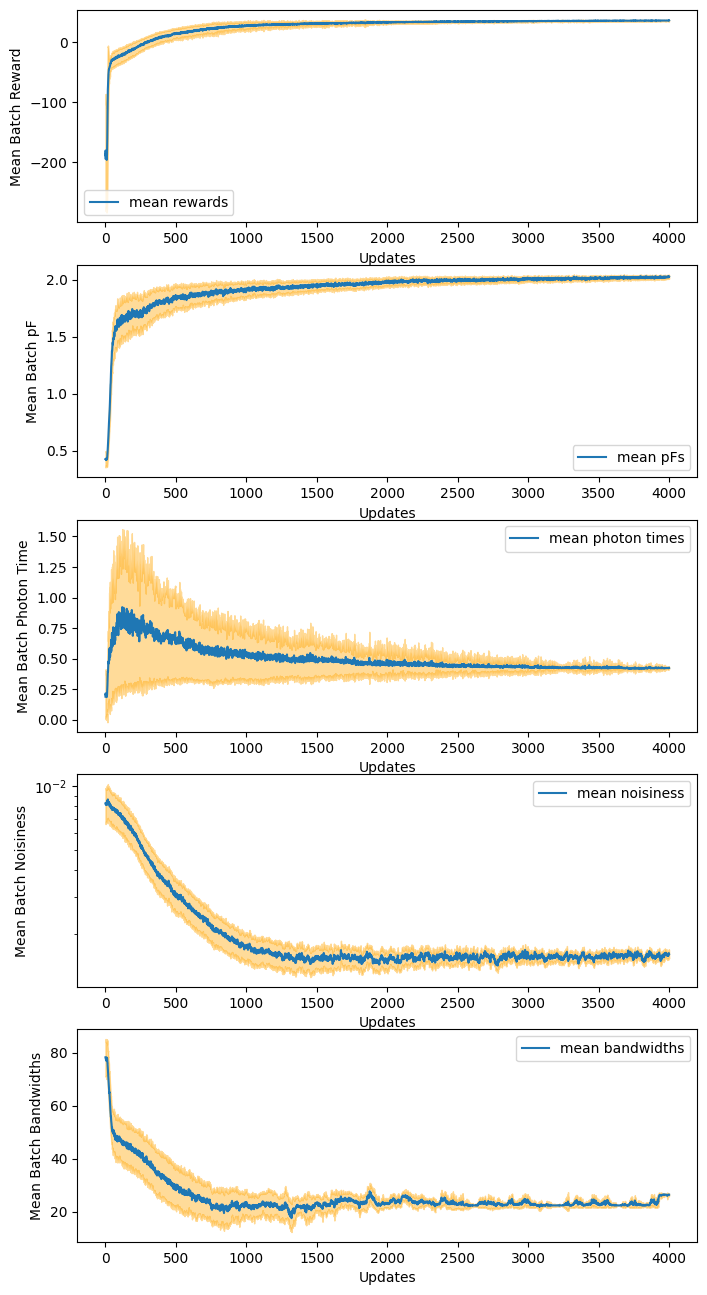

In [37]:
plot_learning(
    rewards=rewards_2,
    max_pFs=max_pFs_2,
    photon_times=photon_times_2,
    smoothnesses=smoothnesses_2,
    bandwidths=bandwidths_2,
)

In [40]:
env_2 = photon_env_dicts()[config_2["ENV_NAME"]](**config_2["ENV_PARAMS"])

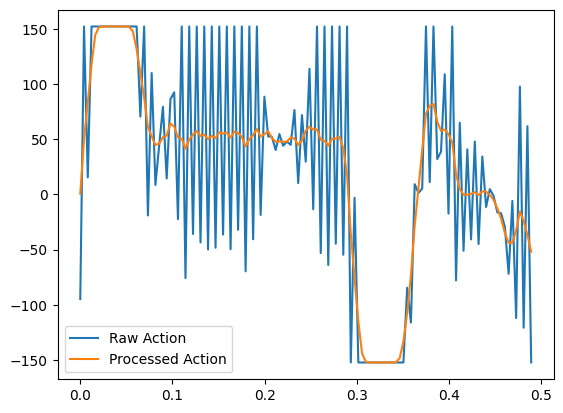

In [41]:
final_action_2 = -actions_2[-1, 0]
final_processed_action_2 = env_2.prepare_action(final_action_2)

plt.plot(env_2.ts_action, final_action_2 * env_2.a0, label='Raw Action')
plt.plot(env_2.ts_action, final_processed_action_2, label='Processed Action')
plt.legend()
plt.show()

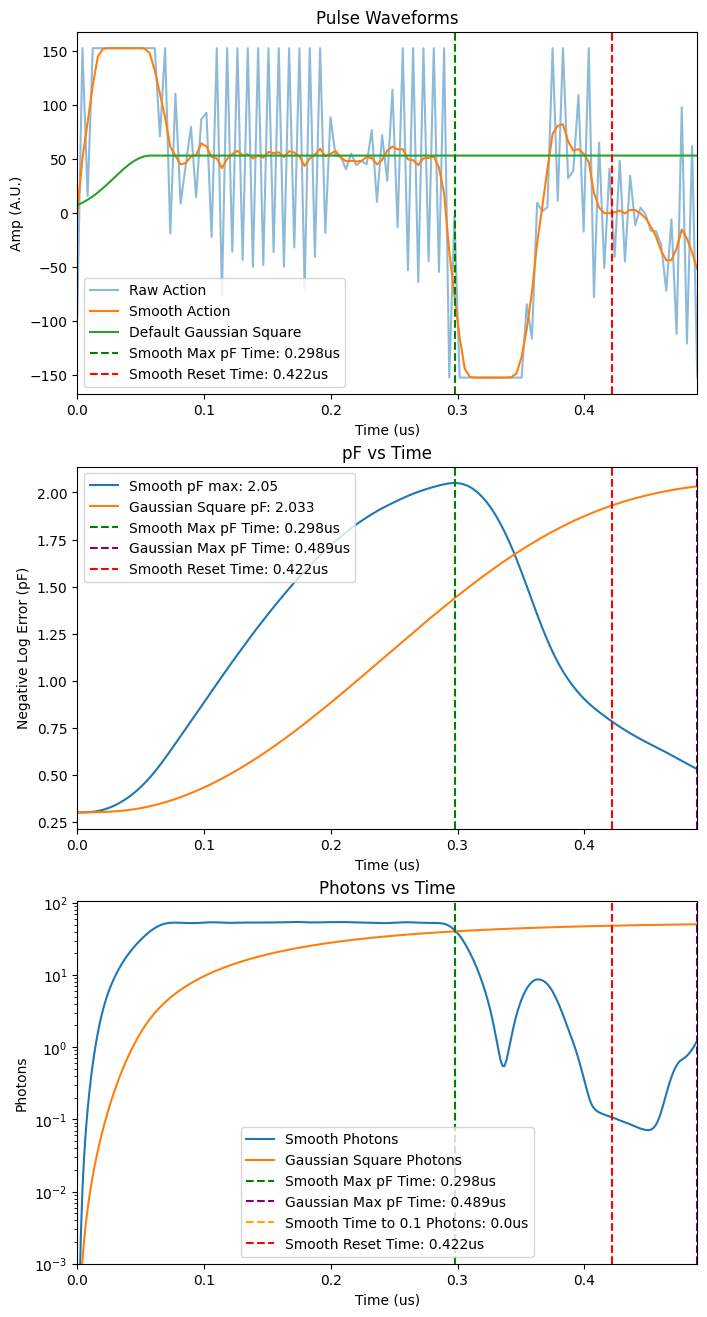

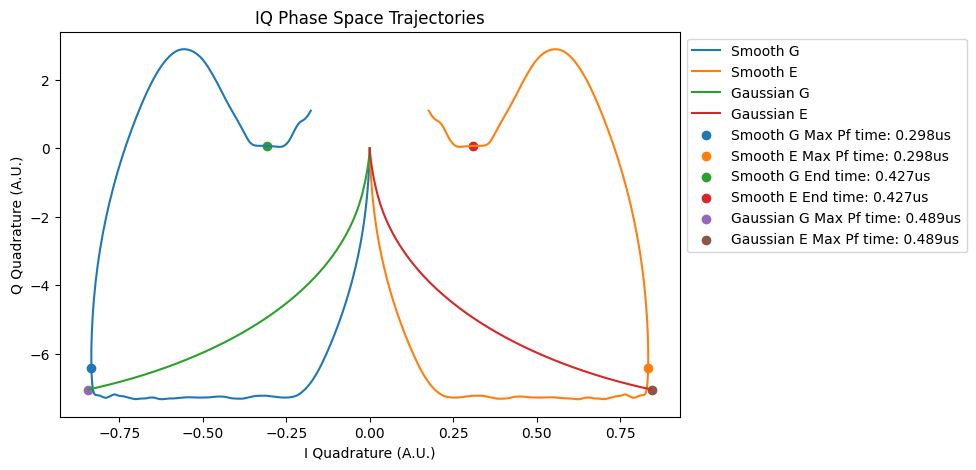

In [42]:
env_2.rollout_action(_rng, final_action_2, photon_log_scale=True)

In [43]:
# Comparing Photon Validity

n0_approx = n0 * (1. - 2. * jnp.exp(-0.5 * kappa * tau_0) + jnp.exp(-kappa * tau_0))
n0_exact = n0 * (1. - 2. * jnp.exp(-0.5 * kappa * tau_0) * jnp.cos(0.5 * chi * tau_0) + jnp.exp(-kappa * tau_0))

print(f"N0 Approx: {n0_approx}")
print(f"N0 Exact: {n0_exact}")

N0 Approx: 53.40378196264755
N0 Exact: 53.51370905927866
